#Predicting Bitcoin Price

##Data Analysis

Use the exported data from 'Data Collection and Exploration' notebook to create a model for predicting the next day market price of bitcoin.

###Imports

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import random
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt
%matplotlib inline

###Data Munging

Create the outcome variable `next_day`.

In [3]:
data = pd.read_csv('bitcoin_price.csv', index_col='trading_day')

next_day = data['price_usd'].iloc[1:]
data = data.iloc[:-1,:]
data['next_day'] = next_day.values
print data.shape

(2564, 32)


Create features for moving averages for price_usd.

In [4]:
data['ma_price_3'] = pd.rolling_mean(data['price_usd'], 3)
data['ma_price_7'] = pd.rolling_mean(data['price_usd'], 7)


Read in the Google Trends result and merge with the main data set.

<img src='bitcoin_trend2.png' width=400px>

In [5]:
def merge_columns(main, other):
    result = pd.merge(left=main,right=other, how='outer', left_on='date', right_on='date')
    
    return result


trends = pd.read_csv('bitcoin_trends.csv')
data = merge_columns(data, trends)

Select data subset of interest. Early timepoints with very low or sparse data are excluded from analysis.

In [6]:
data = data[(data.date >= '2013-01-01') & (data.date <= '2015-12-31')]
print data.shape

(1095, 35)


In [7]:
data['exchange_vol_usd_log'] = np.log10(data['exchange_vol_usd'])
data['market_cap_log'] = np.log10(data['market_cap'])
data['transaction_diff'] = data['total_transactions'] - data['total_transactions'].shift(-1)
data['bitcoin_diff'] = data['total_bitcoins'] - data['total_bitcoins'].shift(-1)
data['blockchain_diff'] = data['blockchain_size'] - data['blockchain_size'].shift(-1)

data = data.dropna()
print data.shape

(1094, 40)


###Correlations

Based on the pairplot from the previous section, high correlations (>0.8) were identified between the ff. independent variables: 

- Group 1: block_size, block_transactions, blockchain_size, difficulty, hash_rate, all_transactions, sub10000_transactions, sub10_transactions, sub10_transactions, sub100_transactions, sub1000_transactions, short_transactions, nonpopular_transactions, unique_addresses, and total_transactions

- Group 2: transaction_cost, price_usd, miners_revenue, deficit, and market_cap

Some features within the same group will be excluded during feature selection to avoid multicollinearity among independent variables.

Mid to high correlations (<0.4) were identified between the outcome `next_day` and the ff. independent variables:

In [8]:
corrs = data.corr()['next_day'].sort_values()
positive_corrs = corrs[corrs > 0.4]
negative_corrs = corrs[corrs < -0.4]
print positive_corrs, negative_corrs


exchange_vol_usd        0.411838
percent_cost            0.429024
exchange_vol_usd_log    0.516363
transaction_fees_usd    0.561606
market_cap_log          0.843815
transaction_cost        0.894501
miners_revenue          0.976649
ma_price_7              0.986287
market_cap              0.988849
ma_price_3              0.992316
price_usd               0.995632
next_day                1.000000
Name: next_day, dtype: float64 deficit            -0.976566
transaction_fees   -0.475625
Name: next_day, dtype: float64


In [9]:
cols = positive_corrs.index
cols += negative_corrs.index
selected_columns = list(set(cols) - set(['Unnamed: 0']))

df = data[selected_columns]
print df.head()

      next_day  ma_price_7    market_cap  exchange_vol_usd  percent_cost  \
1459  13.40000   13.558540  1.439809e+08     385760.190995      3.488328   
1460  13.46400   13.558697  1.423237e+08     185387.359079      1.644697   
1461  13.48986   13.557840  1.430574e+08     289720.324444      2.554070   
1462  13.54800   13.534977  1.433797e+08     324014.732335      1.657939   
1463  13.52999   13.517549  1.440481e+08     330088.300961      1.914935   

      transaction_fees  transaction_fees_usd  price_usd  ma_price_3  \
1459         23.374769            316.985249   13.56100   13.573660   
1460         29.181981            391.038547   13.40000   13.517000   
1461         35.682688            480.431709   13.46400   13.475000   
1462         42.898405            578.693484   13.48986   13.451287   
1463         30.064028            407.307446   13.54800   13.500620   

           deficit  miners_revenue  transaction_cost  market_cap_log  \
1459 -55283.114751     55912.00300          

/Users/Tenorio/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  from IPython.kernel.zmq import kernelapp as app


### Ordinary Least-Squares Regression Model

In [10]:
print selected_columns

['next_day', 'ma_price_7', 'market_cap', 'exchange_vol_usd', 'percent_cost', 'transaction_fees', 'transaction_fees_usd', 'price_usd', 'ma_price_3', 'deficit', 'miners_revenue', 'transaction_cost', 'market_cap_log', 'exchange_vol_usd_log']


In [11]:
lm = smf.ols('next_day ~  ma_price_7 + market_cap + market_cap_log + percent_cost + transaction_fees + transaction_fees_usd + price_usd + ma_price_3 + deficit + miners_revenue + transaction_cost + exchange_vol_usd_log', data=df)
fit = lm.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:               next_day   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.052e+04
Date:                Mon, 25 Jan 2016   Prob (F-statistic):               0.00
Time:                        15:40:02   Log-Likelihood:                -4840.1
No. Observations:                1094   AIC:                             9706.
Df Residuals:                    1081   BIC:                             9771.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept              -19.2868 

Next step is to look at the P-values of each feature to determine suitability for inclusion in further analysis. The variables exchange_vol_usd and transaction_fees_usd have high P values and may be removed to simplify the model. In addition, a large condition number suggests strong multicollinearity which may be related to due the direct relationships among them, so they will be excluded from the simplified model. 

In [12]:
lm2 = smf.ols('next_day ~ price_usd + transaction_cost', data=df)
fit = lm2.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:               next_day   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 6.210e+04
Date:                Mon, 25 Jan 2016   Prob (F-statistic):               0.00
Time:                        15:40:04   Log-Likelihood:                -4853.6
No. Observations:                1094   AIC:                             9713.
Df Residuals:                    1091   BIC:                             9728.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            2.4052      1.153  

Use statsmodels to plot the residuals.

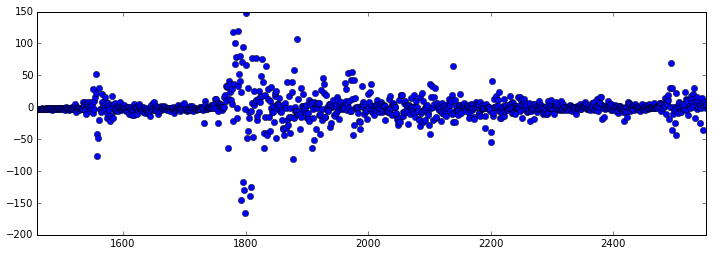

In [13]:
fit.resid.plot(style='o', figsize=(12,4))

###Linear Regression Analysis

Split the data into training and test set.

In [14]:
features = list(set(selected_columns) - set(['next_day']))
y = df['next_day']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Define the method to generate a regression model.

In [15]:
def regression_model(predictor):
    regressor= LinearRegression()

    regressor.fit(X_train[predictor], y_train)
    predictions = regressor.predict(X_test[predictor])
    mse = sum((predictions - y_test) ** 2) / len(predictions)
    score = regressor.score(X_test[predictor], y_test)
    
    return regressor, predictions, mse, score

Define the method to visualize the model statistics. Make scatterplots with the actual values in the training set and test set.

In [16]:
def draw_scatterplot(predictor, regressor, predictions):
    plt.scatter(X_test[predictor], y_test)
    plt.plot(X_test[predictor], predictions)
    plt.show()

    
def print_stats(title, mse, score):
    print 'Predictor: ', title 
    print 'MSE: ', mse
    print 'Score: ', score, "\n"
    

Try out different models parameters.

Predictor:  Exchange Volume in USD
MSE:  35077.1465123
Score:  0.257875529072 

Predictor:  Transaction cost
MSE:  9560.39660249
Score:  0.797731429836 

Predictor:  Seven-day moving average of bitcoin price
MSE:  1040.96707019
Score:  0.977976340352 

Predictor:  Three-day moving average of bitcoin price
MSE:  564.445617013
Score:  0.988058067815 

Predictor:  Daily price of bitcoin
MSE:  332.908498156
Score:  0.992956680699 



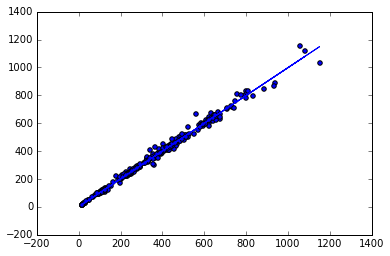

In [18]:
rm , predictions, mse, score = regression_model(['exchange_vol_usd_log'])
print_stats('Exchange Volume in USD', mse, score) 

rm , predictions, mse, score = regression_model(['transaction_cost'])
print_stats('Transaction cost', mse, score)

rm , predictions, mse, score = regression_model(['ma_price_7'])
print_stats('Seven-day moving average of bitcoin price', mse, score)

rm , predictions, mse, score = regression_model(['ma_price_3'])
print_stats('Three-day moving average of bitcoin price', mse, score)

rm , predictions, mse, score = regression_model(['price_usd'])
print_stats('Daily price of bitcoin', mse, score)
draw_scatterplot('price_usd', rm, predictions)


In [26]:
rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_3'])
print_stats('Daily price of bitcoin and three-day moving average', mse, score)

rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_7'])
print_stats('Daily price of bitcoin, three-day and seven-day moving averages', mse, score)

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_cost'])
print_stats('Daily price of bitcoin and transaction cost', mse, score)

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_cost', 'transaction_fees'])
print_stats('Daily price of bitcoin, transaction cost and transaction fees', mse, score)

Predictor:  Daily price of bitcoin and three-day moving average
MSE:  445.530313722
Score:  0.990560581133 

Predictor:  Daily price of bitcoin, three-day and seven-day moving averages
MSE:  438.213863059
Score:  0.99071559425 

Predictor:  Daily price of bitcoin and transaction cost
MSE:  437.744384172
Score:  0.990725541065 

Predictor:  Daily price of bitcoin, transaction cost and transaction fees
MSE:  440.19723445
Score:  0.990673572702 



### Ridge CV

In [20]:
features = list(set(selected_columns) - set(['next_day']))
y = df['next_day']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rcv = RidgeCV(cv=10)
rcv.fit(X, y)
print rcv.score(X_test, y_test)
print rcv

0.991078894692
RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)


###NEXT: FORECASTING